### Visualisation

In [30]:
import numpy as np

def concentration(x, y, z, t,
                  m_dot,      # 排放率 \dot m
                  Ux, Uy, Um, # 背景流 Ux, 横向风 Uy, 船速 Um
                  DT,         # 横向/竖向湍扩散系数 D_T
                  h):         # 源高度 h（到海面距离）

    """
    高斯羽流 + perfect reflector 的浓度场 C(x, y, z, t)

    参数支持 numpy 数组，所以可以直接传入 meshgrid.
    """

    U_rel = Ux + Um  # 相对流速

    # sigma^2 = 2 D_T (x - Um t) / (Ux + Um)
    sigma2 = 2.0 * DT * (x - Um * t) / U_rel

    # 为了避免上游 (x < Um t) 出现负的 sigma^2，直接把那一侧浓度设为 0
    sigma2 = np.where(sigma2 > 0, sigma2, np.nan)

    # 公共的横向位移项: y - Uy/(Ux+Um) * (x - Ux t)
    y0 = y - (Uy / U_rel) * (x - Ux * t)

    # 两个镜像源：z = h 和 z = -h
    denom = 2.0 * sigma2
    prefactor = m_dot / (2.0 * np.pi * U_rel * sigma2)

    expo1 = - (y0**2 + (z - h)**2) / denom
    expo2 = - (y0**2 + (z + h)**2) / denom

    C = prefactor * (np.exp(expo1) + np.exp(expo2))

    # 把 NaN 的地方（上游）改成 0，更方便画图
    C = np.nan_to_num(C, nan=0.0)

    return C

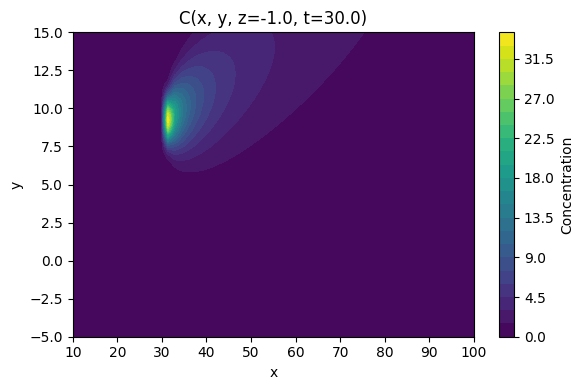

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 参数示例
m_dot = 100.0      # g/s
Ux, Uy, Um = -0.5, 0.1, 1
DT = 0.2
h = 1.0
t = 30.0
z0 = -1.0         # 取和源高度差不多的一个水平面

# 网格
x = np.linspace(10,100 , 60)
y = np.linspace(-5, 15, 60)
X, Y = np.meshgrid(x, y)
Z = z0 * np.ones_like(X)

C = concentration(X, Y, Z, t, m_dot, Ux, Uy, Um, DT, h)

plt.figure(figsize=(6, 4))
cs = plt.contourf(X, Y, C, levels=30)
plt.colorbar(cs, label='Concentration')
plt.xlabel('x')
plt.ylabel('y')
plt.title('C(x, y, z={:.1f}, t={:.1f})'.format(z0, t))
plt.tight_layout()
plt.show()

In [32]:
import numpy as np

def concentration(x, y, z, t,
                  m_dot,      # 排放率
                  Ux, Uy, Um, # 背景流 Ux, 侧向风 Uy, 载体速度 Um
                  DT,         # 扩散系数 D_T
                  h):         # 源高度

    U_rel = Ux + Um

    # sigma^2 = 2 D_T (x - Um t) / (Ux + Um)
    sigma2 = 2.0 * DT * (x - Um * t) / U_rel
    sigma2 = np.where(sigma2 > 0, sigma2, np.nan)  # 上游丢掉

    # 横向平移项
    y0 = y - (Uy / U_rel) * (x - Ux * t)

    denom = 2.0 * sigma2
    prefactor = m_dot / (2.0 * np.pi * U_rel * sigma2)

    expo1 = - (y0**2 + (z - h)**2) / denom   # 真源
    expo2 = - (y0**2 + (z + h)**2) / denom   # 镜像源（perfect reflector）

    C = prefactor * (np.exp(expo1) + np.exp(expo2))

    return np.nan_to_num(C, nan=0.0)

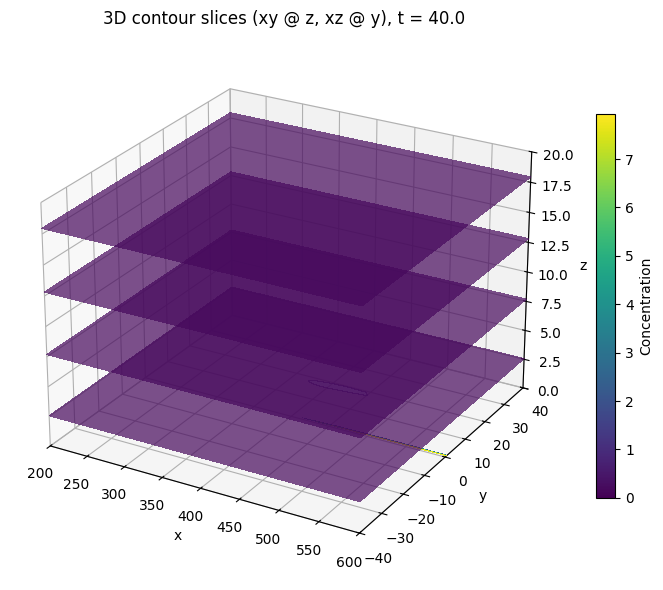

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

# ========= 参数 =========
m_dot = 100
Ux, Uy, Um = -0.5, 0.1, 10
DT = 0.3
h = 1.0
t = 40.0

# x>Um*t=400 才有 plume，这里画 200~600
x = np.linspace(200, 600, 80)
y = np.linspace(-40, 40, 60)
z = np.linspace(0, 20, 40)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
C = concentration(X, Y, Z, t, m_dot, Ux, Uy, Um, DT, h)

# ========= 选截面 =========
# 方式一：按索引选（简单粗暴，直接改这两行就行）
z_indices = [5, 15, 25, 35]       # 几个 z 截面（xy 平面）
y_indices = [10, 30, 50]          # 几个 y 截面（xz 平面）

# 方式二（可选）：如果你想指定物理高度，比如 z = 0.5, 1, 2，可以：
# target_z = [0.5, 1.0, 2.0]
# z_indices = [np.argmin(np.abs(z - zz)) for zz in target_z]
# 同理可对 y 做一遍

levels = np.linspace(C.min(), C.max(), 25)
norm = Normalize(vmin=C.min(), vmax=C.max())
cmap = cm.viridis

# ========= 画图 =========
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# ---- 多个 z = const 的 xy 平面 ----
for k in z_indices:
    X_z = X[:, :, k]     # shape: (len(x), len(y))
    Y_z = Y[:, :, k]
    C_z = C[:, :, k]
    ax.contourf(X_z, Y_z, C_z,
                zdir='z', offset=z[k],     # 固定 z
                levels=levels,
                cmap=cmap,
                alpha=0.7)

# ---- 多个 y = const 的 xz 平面 ----
for j in y_indices:
    X_y = X[:, j, :]     # shape: (len(x), len(z))
    Z_y = Z[:, j, :]
    C_y = C[:, j, :]
    ax.contourf(X_y, Z_y, C_y,
                zdir='y', offset=y[j],     # 固定 y
                levels=levels,
                cmap=cmap,
                alpha=0.7)

# 轴范围
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(z.min(), z.max())

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f'3D contour slices (xy @ z, xz @ y), t = {t:.1f}')

# 颜色条
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(C)
fig.colorbar(mappable, ax=ax, shrink=0.7, label='Concentration')

# 视角
ax.view_init(elev=25, azim=-60)
plt.tight_layout()
plt.show()